In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import string

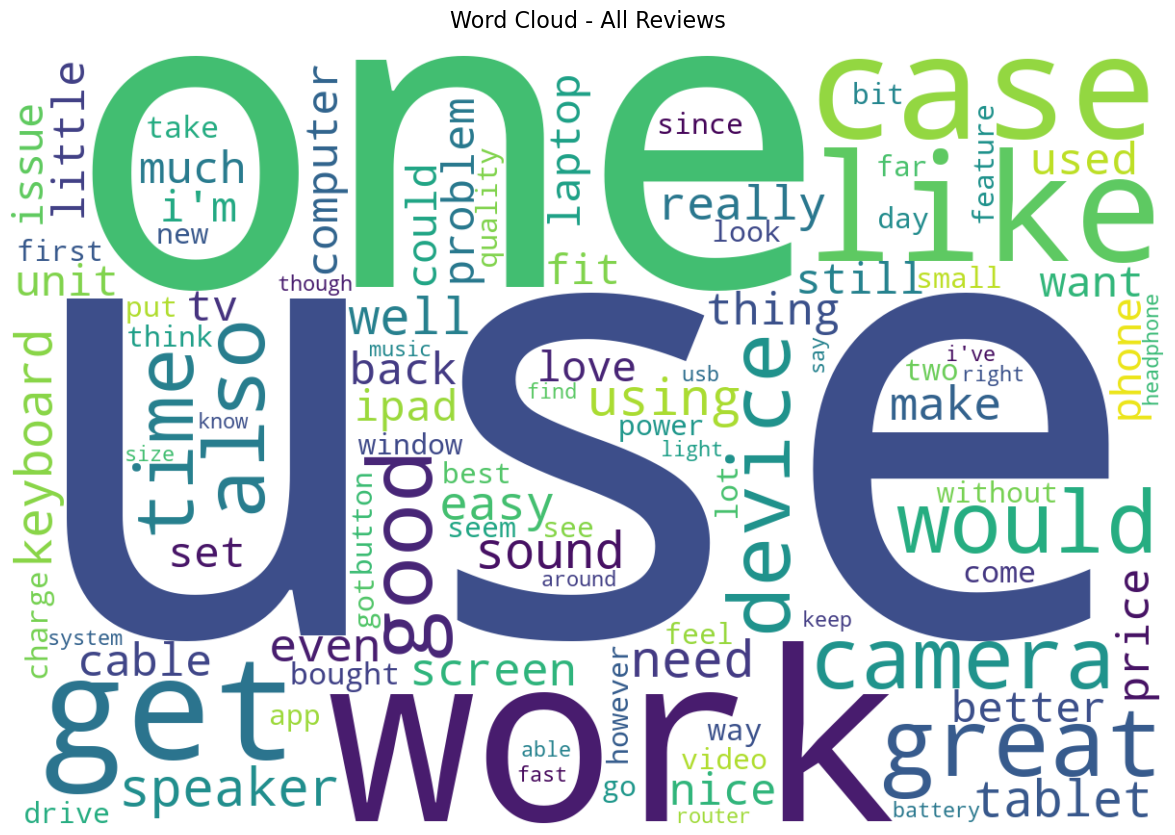

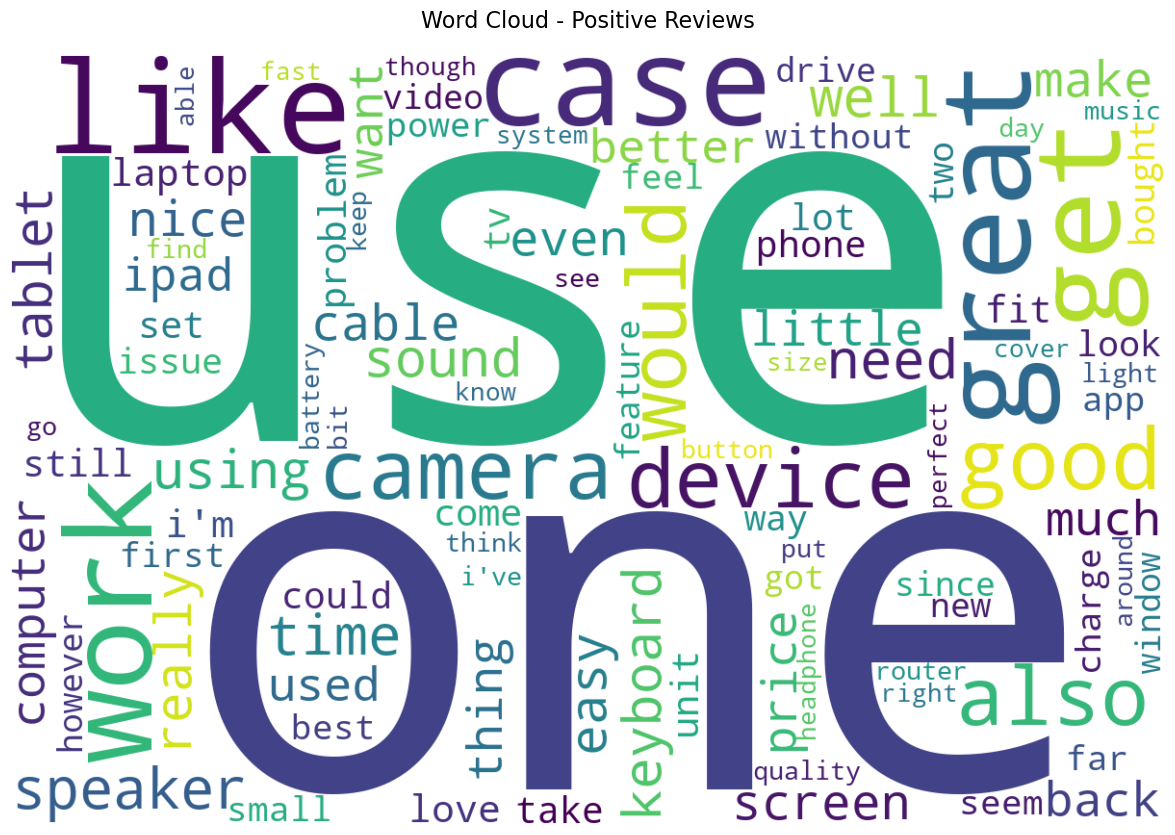

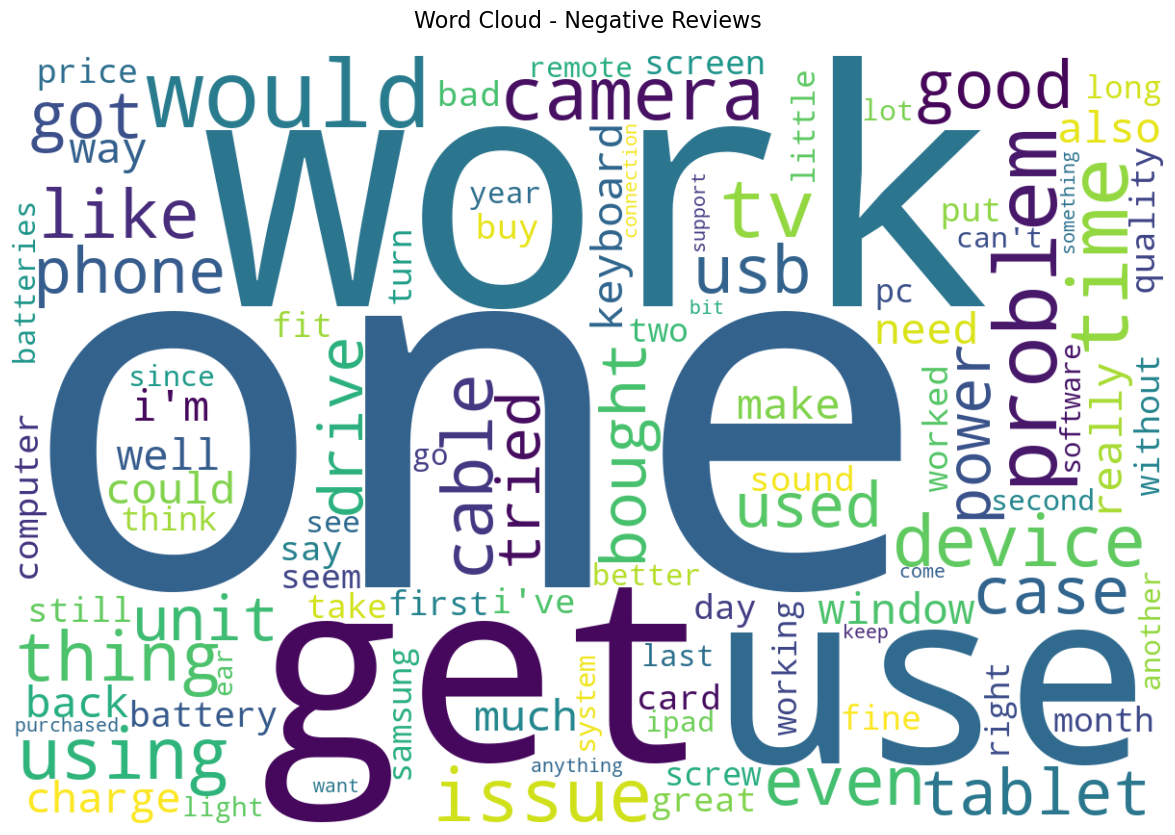

In [18]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string

def create_wordcloud_from_raw(input_file, sentiment=None):
    """
    Create and display a word cloud from the raw review_text column
    
    Parameters:
    input_file (str): Path to the CSV file
    sentiment (str): Optional - 'positive' or 'negative' to filter by sentiment
    """
    # Read the dataset
    df = pd.read_csv(input_file)
    
    # Filter by sentiment if specified
    if sentiment:
        df = df[df['sentiment'] == sentiment]
    
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    
    # Additional custom stop words relevant to reviews
    custom_stops = {'amazon', 'product', 'review', 'stars', 'star', 'rating'}
    stop_words.update(custom_stops)
    
    # Create and configure the WordCloud object
    wordcloud = WordCloud(
        width=1200, 
        height=800,
        background_color='white',
        max_words=100,
        stopwords=stop_words,
        collocations=True,  # Include common word pairs
        contour_width=3,
        contour_color='steelblue'
    )
    
    # Combine all review text into one string
    text = ' '.join(df['reviewText'].dropna().astype(str).str.lower())
    
    # Generate word cloud
    wordcloud = wordcloud.generate(text)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Add title based on sentiment
    title = "Word Cloud - "
    title += f"{sentiment.capitalize()} Reviews" if sentiment else "All Reviews"
    plt.title(title, fontsize=16, pad=20)
    
    plt.show()

# Generate word clouds
input_file = "../data/processed/cleaned_sentiment_analysis_reviews.csv"

# Create three different word clouds
create_wordcloud_from_raw(input_file)  # All reviews
create_wordcloud_from_raw(input_file, sentiment='positive')  # Positive reviews only
create_wordcloud_from_raw(input_file, sentiment='negative')  # Negative reviews only

All Reviews Word Cloud:
- Most prominent terms: "use," "one," "like," "work," "camera"
- Device-specific terms: "camera," "tablet," "speaker," "computer"
- Action words: "take," "make," "work," "need"
- Descriptive terms: "good," "better," "nice," "well"
- Interface elements: "screen," "keyboard," "app"

Positive Reviews Word Cloud:
- Strong positive descriptors: "good," "great," "nice," "better," "well"
- Usage-related terms: "use," "using," "used"
- Product categories: "camera," "laptop," "iPad," "device"
- Ease of use indicators: "easy," "time," "could," "best"
- Feature-focused words: "screen," "quality," "sound," "keyboard"

Negative Reviews Word Cloud:
- Problem indicators: "work," "get," "one," "would"
- Technical issues: "battery," "cable," "drive," "pc"
- Hardware components: "keyboard," "screen," "usb," "device"
- Time-related issues: "time," "year," "month," "day"
- Conditional language: "would," "could," "tried"

Key Patterns and Insights:
1. Product Focus
   - Electronics and devices dominate all reviews
   - Strong focus on physical components and interfaces
   - Multiple device types mentioned across sentiments

2. Usage Patterns
   - Positive reviews emphasize successful use and functionality
   - Negative reviews focus on problems and attempts to resolve issues
   - Both mention time-related aspects differently (positive: duration of use; negative: time wasted/issues)

3. Sentiment Indicators
   - Positive reviews contain more descriptive adjectives
   - Negative reviews show more problem-solving attempts
   - Technical terms appear more frequently in negative reviews

4. Customer Experience
   - Positive reviews highlight ease of use and quality
   - Negative reviews emphasize technical difficulties and hardware problems
   - Both types of reviews focus on practical usage rather than emotional responses

[nltk_data] Downloading package punkt to /Users/yizu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yizu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


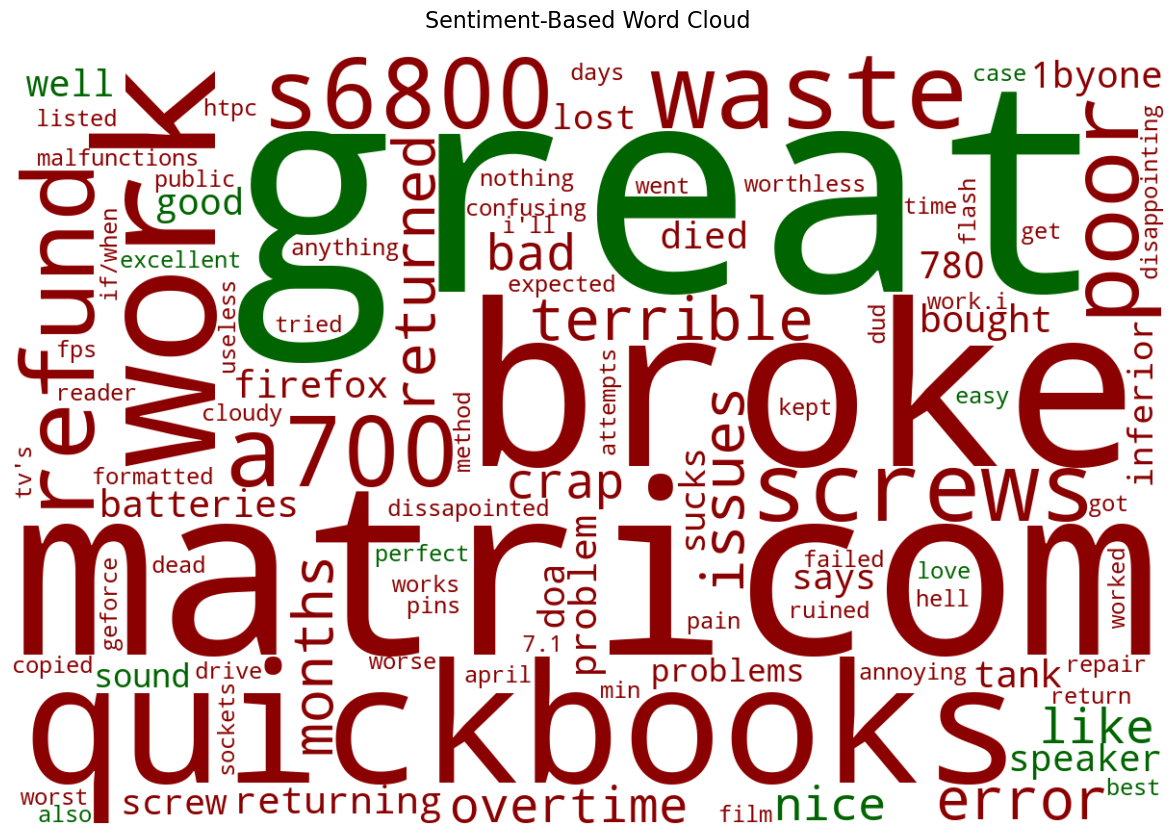

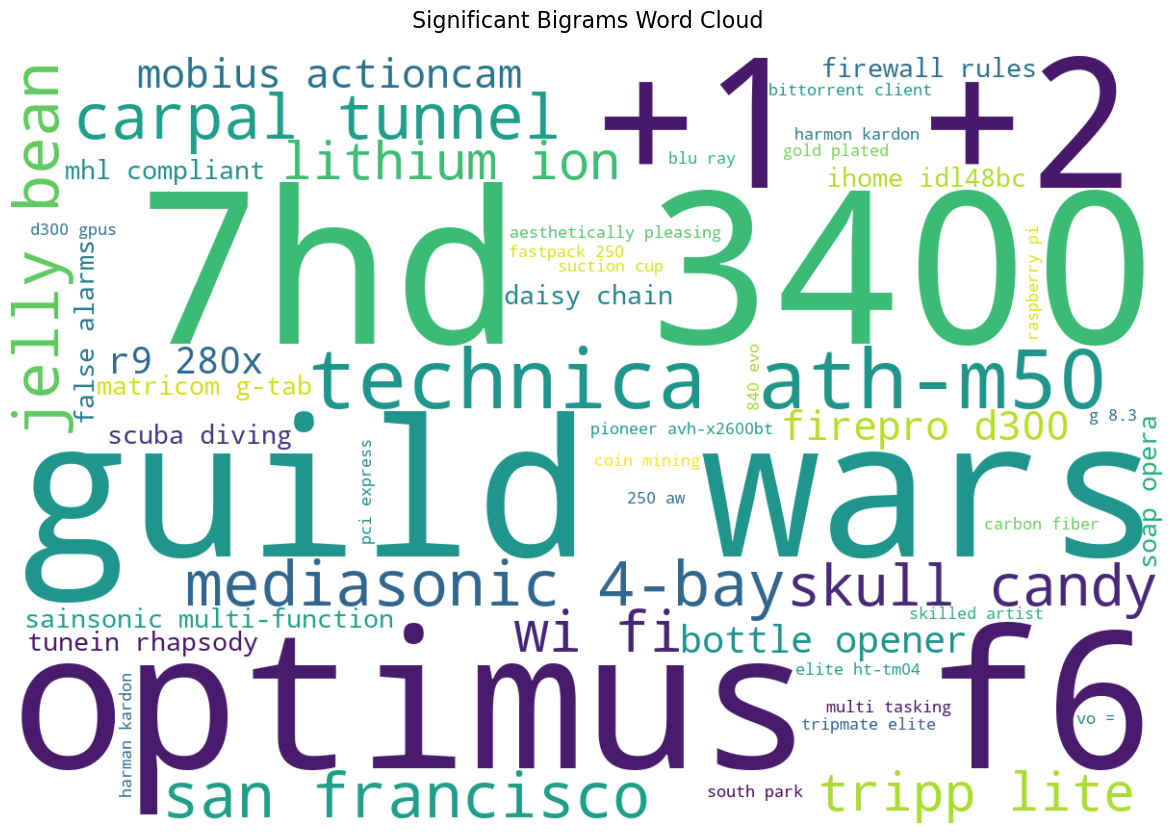

In [17]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
import seaborn as sns

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def simple_tokenize(text):
    """Simple tokenization function that splits on whitespace and punctuation"""
    if isinstance(text, str):
        # Split on whitespace and remove punctuation
        words = text.lower().split()
        return [word.strip('.,!?()[]{}:;"\'-') for word in words]
    return []

def calculate_word_significance(df, column='review_text', class_column='sentiment', 
                              class_value='positive', min_freq=5):
    """
    Calculate word significance scores using chi-square test
    """
    # Create two text corpora
    positive_text = ' '.join(df[df[class_column] == class_value][column].fillna(''))
    negative_text = ' '.join(df[df[class_column] != class_value][column].fillna(''))
    
    # Count frequencies using simple tokenization
    pos_words = Counter(simple_tokenize(positive_text))
    neg_words = Counter(simple_tokenize(negative_text))
    
    # Get stopwords to filter
    stop_words = set(stopwords.words('english'))
    
    # Calculate significance scores
    word_scores = {}
    for word in set(list(pos_words.keys()) + list(neg_words.keys())):
        # Skip stopwords and very short words
        if word in stop_words or len(word) < 3:
            continue
            
        pos_freq = pos_words.get(word, 0)
        neg_freq = neg_words.get(word, 0)
        
        if pos_freq + neg_freq >= min_freq:
            # Calculate chi-square score
            total = sum(pos_words.values()) + sum(neg_words.values())
            expected_pos = (pos_freq + neg_freq) * sum(pos_words.values()) / total
            expected_neg = (pos_freq + neg_freq) * sum(neg_words.values()) / total
            
            chi_square = ((pos_freq - expected_pos) ** 2 / expected_pos if expected_pos > 0 else 0) + \
                        ((neg_freq - expected_neg) ** 2 / expected_neg if expected_neg > 0 else 0)
            
            # Determine direction (positive or negative association)
            direction = 1 if pos_freq/sum(pos_words.values()) > neg_freq/sum(neg_words.values()) else -1
            word_scores[word] = chi_square * direction
    
    return word_scores

def create_comparative_wordcloud(df, word_scores, title="Comparative Word Cloud"):
    """
    Create a word cloud where color indicates positive/negative association
    and size indicates significance
    """
    # Create color function
    def color_func(word, font_size, position, orientation, font_path, random_state):
        score = word_scores.get(word, 0)
        if score > 0:
            return "rgb(0, 100, 0)"  # Dark green for positive
        else:
            return "rgb(139, 0, 0)"  # Dark red for negative
    
    # Create word cloud
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=100,
        color_func=color_func
    )
    
    # Generate from frequencies
    frequencies = {word: abs(score) for word, score in word_scores.items()}
    wordcloud.generate_from_frequencies(frequencies)
    
    # Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.show()

def analyze_word_patterns(input_file):
    """
    Perform advanced word cloud analysis
    """
    # Read data
    df = pd.read_csv(input_file)
    
    # 1. Calculate word significance scores
    word_scores = calculate_word_significance(df)
    
    # 2. Create comparative word cloud
    create_comparative_wordcloud(df, word_scores, "Sentiment-Based Word Cloud")
    
    # 3. Analyze bigram patterns
    text = ' '.join(df['review_text'].fillna(''))
    tokens = simple_tokenize(text)
    
    # Create bigram finder
    finder = BigramCollocationFinder.from_words(tokens)
    
    # Apply frequency filter to remove rare bigrams
    finder.apply_freq_filter(3)
    
    # Score bigrams using PMI
    bigram_measures = BigramAssocMeasures()
    scored_bigrams = finder.score_ngrams(bigram_measures.pmi)
    
    # Create bigram word cloud
    bigram_frequencies = {' '.join(bigram): score for bigram, score in scored_bigrams[:100]}
    
    bigram_cloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(bigram_frequencies)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(bigram_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Significant Bigrams Word Cloud", fontsize=16, pad=20)
    plt.show()

# Run the analysis
input_file = "../data/processed/final_sentiment_analysis_data.csv"
analyze_word_patterns(input_file)

In [ ]:
'''
Sentiment-Based Word Cloud Analysis:

Green Words (Positive Associations):

"good" - standard positive descriptor
"well" - indicates satisfaction with product performance
"easy" - suggests user-friendly products
"excellent" - strong positive sentiment

Red Words (Negative Associations):

"quickbooks" appearing prominently in red suggests frequent complaints/issues with this software
"broke/broken" - indicates reliability issues
"terrible" - strong negative sentiment
"bad" - direct negative feedback
"waste" - suggests dissatisfaction with value/time
"s6800" and "700" appearing in red might indicate specific problematic product models
"return" - suggests product dissatisfaction leading to returns


Significant Bigrams Word Cloud:

Product Categories and Technical Terms:

"carpal tunnel" - likely related to ergonomic concerns/products
"lithium ion" - battery technology discussions
"7hd", "3400", "ath-m50" - specific product model numbers
"guild wars" - gaming related discussions
"optimus" - likely referring to LG Optimus products
"firewall rules" - security-related discussions
"mediasonic" - brand/product mentions
"san francisco" - location-based context

Key Insights:

Quality Issues:

There's a significant focus on product reliability problems (broke, waste, terrible)
QuickBooks appears to have notable user dissatisfaction


Technical Products:

Reviews cover a wide range of technical products (audio equipment, batteries, security products)
Specific model numbers are frequently discussed, suggesting detailed technical reviews


Usage Patterns:

Ergonomic concerns appear important (carpal tunnel mentions)
Gaming and entertainment products have significant presence
Professional software (QuickBooks) generates substantial discussion


Customer Behavior:

"Return" prominence suggests active customer response to dissatisfaction
Technical specifications are important to reviewers (model numbers, technical terms)
'''

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
import seaborn as sns

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def simple_tokenize(text):
    """Simple tokenization function that splits on whitespace and punctuation"""
    if isinstance(text, str):
        # Split on whitespace and remove punctuation
        words = text.lower().split()
        return [word.strip('.,!?()[]{}:;"\'-') for word in words]
    return []

def calculate_word_significance(df, column='reviewText', class_column='sentiment', 
                              class_value='positive', min_freq=5):
    """
    Calculate word significance scores using chi-square test
    """
    # Create two text corpora
    positive_text = ' '.join(df[df[class_column] == class_value][column].fillna(''))
    negative_text = ' '.join(df[df[class_column] != class_value][column].fillna(''))
    
    # Count frequencies using simple tokenization
    pos_words = Counter(simple_tokenize(positive_text))
    neg_words = Counter(simple_tokenize(negative_text))
    
    # Get stopwords to filter
    stop_words = set(stopwords.words('english'))
    
    # Calculate significance scores
    word_scores = {}
    for word in set(list(pos_words.keys()) + list(neg_words.keys())):
        # Skip stopwords and very short words
        if word in stop_words or len(word) < 3:
            continue
            
        pos_freq = pos_words.get(word, 0)
        neg_freq = neg_words.get(word, 0)
        
        if pos_freq + neg_freq >= min_freq:
            # Calculate chi-square score
            total = sum(pos_words.values()) + sum(neg_words.values())
            expected_pos = (pos_freq + neg_freq) * sum(pos_words.values()) / total
            expected_neg = (pos_freq + neg_freq) * sum(neg_words.values()) / total
            
            chi_square = ((pos_freq - expected_pos) ** 2 / expected_pos if expected_pos > 0 else 0) + \
                        ((neg_freq - expected_neg) ** 2 / expected_neg if expected_neg > 0 else 0)
            
            # Determine direction (positive or negative association)
            direction = 1 if pos_freq/sum(pos_words.values()) > neg_freq/sum(neg_words.values()) else -1
            word_scores[word] = chi_square * direction
    
    return word_scores

def create_comparative_wordcloud(df, word_scores, title="Comparative Word Cloud"):
    """
    Create a word cloud where color indicates positive/negative association
    and size indicates significance
    """
    # Create color function
    def color_func(word, font_size, position, orientation, font_path, random_state):
        score = word_scores.get(word, 0)
        if score > 0:
            return "rgb(0, 100, 0)"  # Dark green for positive
        else:
            return "rgb(139, 0, 0)"  # Dark red for negative
    
    # Create word cloud
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=100,
        color_func=color_func
    )
    
    # Generate from frequencies
    frequencies = {word: abs(score) for word, score in word_scores.items()}
    wordcloud.generate_from_frequencies(frequencies)
    
    # Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.show()

def analyze_word_patterns(input_file):
    """
    Perform advanced word cloud analysis
    """
    # Read data
    df = pd.read_csv(input_file)
    
    # 1. Calculate word significance scores
    word_scores = calculate_word_significance(df)
    
    # 2. Create comparative word cloud
    create_comparative_wordcloud(df, word_scores, "Sentiment-Based Word Cloud")
    
    # 3. Analyze bigram patterns
    text = ' '.join(df['reviewText'].fillna(''))
    tokens = simple_tokenize(text)
    
    # Create bigram finder
    finder = BigramCollocationFinder.from_words(tokens)
    
    # Apply frequency filter to remove rare bigrams
    finder.apply_freq_filter(3)
    
    # Score bigrams using PMI
    bigram_measures = BigramAssocMeasures()
    scored_bigrams = finder.score_ngrams(bigram_measures.pmi)
    
    # Create bigram word cloud
    bigram_frequencies = {' '.join(bigram): score for bigram, score in scored_bigrams[:100]}
    
    bigram_cloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(bigram_frequencies)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(bigram_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Significant Bigrams Word Cloud", fontsize=16, pad=20)
    plt.show()

# Run the analysis
input_file = "../data/processed/cleaned_sentiment_analysis_reviews.csv"
analyze_word_patterns(input_file)

[nltk_data] Downloading package punkt to /Users/yizu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/yizu/nltk_data'
    - '/opt/anaconda3/envs/sa_env/nltk_data'
    - '/opt/anaconda3/envs/sa_env/share/nltk_data'
    - '/opt/anaconda3/envs/sa_env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:


def preprocess_text(text):
    """Tokenize and preprocess text by splitting and removing punctuation."""
    if isinstance(text, str):
        return [word.strip(string.punctuation).lower() for word in text.split() if word.isalpha()]
    return []


def analyze_keywords(input_file):
    # Read the dataset
    df = pd.read_csv(input_file)

    # Ensure the 'processed_text' column exists
    if 'processed_text' not in df.columns:
        raise ValueError(
            "The dataset must include a 'processed_text' column with raw text.")

    # Preprocess the 'processed_text' column to tokenize it into lists
    df['processed_text'] = df['processed_text'].apply(preprocess_text)

    # Separate the data by sentiment
    positive_reviews = df[df['sentiment'] == 'positive']['processed_text']
    negative_reviews = df[df['sentiment'] == 'negative']['processed_text']

    # Flatten the tokenized reviews into a single list of words
    positive_words = [word for review in positive_reviews for word in review]
    negative_words = [word for review in negative_reviews for word in review]

    # Count word frequencies
    positive_word_counts = Counter(positive_words)
    negative_word_counts = Counter(negative_words)

    # Get the top 10 most frequent words
    top_positive_keywords = positive_word_counts.most_common(10)
    top_negative_keywords = negative_word_counts.most_common(10)

    # Display the results
    print("\nTop 10 Positive Keywords:")
    print(pd.DataFrame(top_positive_keywords,
          columns=["Keyword", "Frequency"]))

    print("\nTop 10 Negative Keywords:")
    print(pd.DataFrame(top_negative_keywords,
          columns=["Keyword", "Frequency"]))


if __name__ == "__main__":
    # Replace with your file path
    input_file = "../data/processed/cleaned_sentiment_analysis_reviews.csv"
    analyze_keywords(input_file)


Top 10 Positive Keywords:
  Keyword  Frequency
0     not       2742
1      so       1987
2    very       1803
3   great       1759
4     one       1645
5     use       1609
6     can       1595
7    like       1500
8     all       1458
9    good       1397

Top 10 Negative Keywords:
  Keyword  Frequency
0     not        412
1     one        175
2      so        168
3      no        142
4     get        129
5    very        127
6    when        126
7    will        120
8   would        117
9     use        112


In [2]:
import pandas as pd
from collections import Counter
from itertools import tee

def tokenize_simple(text):
    """Tokenize text by splitting on spaces."""
    if isinstance(text, str):
        return [word.lower().strip() for word in text.split() if word.isalpha()]
    return []


def generate_bigrams(tokens):
    """Generate bigrams from a list of tokens."""
    a, b = tee(tokens)
    next(b, None)
    return list(zip(a, b))


def analyze_not_usage(input_file):
    # Read the dataset
    df = pd.read_csv(input_file)

    # Ensure the 'processed_text' column exists
    if 'processed_text' not in df.columns:
        raise ValueError(
            "The dataset must include a 'processed_text' column with raw text.")

    # Preprocess the 'processed_text' column to tokenize it into lists
    df['processed_text'] = df['processed_text'].apply(tokenize_simple)

    # Filter positive reviews containing "not"
    positive_reviews = df[df['sentiment'] == 'positive']['processed_text']
    positive_reviews_with_not = positive_reviews[positive_reviews.apply(
        lambda review: 'not' in review)]

    # Extract bigrams for reviews containing "not"
    bigram_counts = Counter()
    for review in positive_reviews_with_not:
        bigrams = generate_bigrams(review)  # Generate bigrams
        bigram_counts.update(bigrams)

    # Filter bigrams where "not" is the first word
    not_bigrams = {bigram: count for bigram,
                   count in bigram_counts.items() if bigram[0] == 'not'}

    # Sort and get the top 10 most common "not" bigrams
    sorted_not_bigrams = sorted(
        not_bigrams.items(), key=lambda x: x[1], reverse=True)[:10]

    # Convert to DataFrame for better visualization
    not_bigrams_df = pd.DataFrame(
        sorted_not_bigrams, columns=["Bigram", "Frequency"])

    # Display results
    print("\nTop 10 'Not' Bigrams in Positive Reviews:")
    print(not_bigrams_df)


# Run the analysis
# Replace with your file path
input_file = "../data/processed/cleaned_sentiment_analysis_reviews.csv"
analyze_not_usage(input_file)


Top 10 'Not' Bigrams in Positive Reviews:
        Bigram  Frequency
0  (not, sure)         74
1  (not, work)         51
2   (not, too)         43
3  (not, only)         41
4   (not, bad)         40
5   (not, use)         36
6  (not, like)         35
7  (not, much)         32
8   (not, big)         31
9  (not, good)         28


In [3]:
import pandas as pd


def extract_phrases_with_bigram(input_file, bigram_to_search):
    # Read the dataset
    df = pd.read_csv(input_file)

    # Ensure the 'processed_text' column exists
    if 'processed_text' not in df.columns:
        raise ValueError(
            "The dataset must include a 'processed_text' column with raw text.")

    # Ensure the raw review text column exists for context
    if 'reviewText' not in df.columns:
        raise ValueError(
            "The dataset must include a 'reviewText' column for full context.")

    # Tokenize the processed_text column
    df['processed_text'] = df['processed_text'].apply(
        lambda x: x.lower().split() if isinstance(x, str) else [])

    # Filter reviews that contain the bigram
    bigram_reviews = df[df['processed_text'].apply(
        lambda tokens: any(tokens[i:i+2] == list(bigram_to_search)
                           for i in range(len(tokens)-1))
    )]

    # Extract the context for each review
    contexts = []
    for _, row in bigram_reviews.iterrows():
        review_text = row['reviewText']
        if isinstance(review_text, str) and " ".join(bigram_to_search) in review_text.lower():
            contexts.append(review_text)

    # Display the sentences containing the bigram
    print(f"\nSentences containing the bigram '{' '.join(bigram_to_search)}':")
    for context in contexts[:10]:  # Limit to 10 examples for clarity
        print(f"- {context.strip()}")


if __name__ == "__main__":
    # Replace with your file path
    input_file = "../data/processed/cleaned_sentiment_analysis_reviews.csv"
    bigram_to_search = ("not", "bad")  # Specify the bigram to search
    extract_phrases_with_bigram(input_file, bigram_to_search)


Sentences containing the bigram 'not bad':
- Got this unit real fast and came in a box wrapped in plastic wrap lol. But hey was all there and not damaged. Easy to assemble and looks and feels great, I had a couple minor issues with this thing you can view on the youtube page if you like to see it. But overall not bad!  http://youtu.be/4RoQHzo-C9k?list=UUZlPl1F9XVcDu12wZ7L1pJw
- I have used many headphones before, so I have a very good idea of what headphones need to sound like.Plantronics is a great headphones:Sound quality is great the bass is very good for a small Bluetooth headphones.Fit factor: The headphones fits very nicely and snugly I do very intensive workouts with it.Battery life: is not the best but it is amazing comparing to the size of the headphones. (The charging case is a great edition to make sure your headphones are charged while in your bag)Connectivity: it is easy to connect and pair with your phone, I love the ability to pair to 8 devices.After all:It is a very go